# Training

In [1]:
# !pip install music21
from music21 import *
import numpy as np
import os
from collections import Counter
from fractions import Fraction

# !pip install tensorflow
from keras.layers import *
from keras.models import *
from keras.callbacks import *
import keras.backend as K
import tensorboard
from datetime import datetime

# !pip install sklearn
from sklearn.model_selection import train_test_split

In [2]:
%load_ext tensorboard

In [3]:
inst = 'Piano'
artist = 'Anime'

$ instrument \in \{Piano, Violin, Flute, Horn, Vocal\} $ <br> <br>
$ instrument = Piano \rightarrow artist \in \{Bach, Beethoven, Chopin, Debussy, Mozart, Ellington, Corea, Anime\}$
$ instrument = Violin \rightarrow artist \in \{Mozart, Paganini, Vivaldi\}$ <br>
$ instrument = Flute \rightarrow artist \in \{Brahms, Wagner\}$ <br>
$ instrument = Horn \rightarrow artist \in \{Mozart, Strauss\}$ <br>
$ instrument = Vocal \rightarrow artist \in \{DaftPunk, Jazz, Pop\}$

In [4]:
# file references
path = "train_music/" + inst + artist + "/"
model_name = inst + artist + ".h5"

unique_x_file = inst + artist + "_unique.txt"
xval_file = inst + artist + "_x.txt"

In [5]:
# hyperparameters
epochs=100 # number of times model runs through train data during training
frequentNoteMin = 10 # model only counts "frequent" notes, specify number times a note/rhythm must appear in train music to be counted
validation=False # include val loss as metric for training - only set to True if overfitting is a clear issue
no_of_timesteps = 32 # SENSITIVE - DO NOT MODIFY, HERE FOR EXPERIMENTAL REASONS, length of sequence to determine next note/rhythm in sequence

In [6]:
def read_midi(file, inst):
    
    print("Loading Music File:",file)
    
    notes=[]
    notes_to_parse = None
    
    #parsing a midi file
    midi = converter.parse(file)
    #midi.show()
  
    #grouping based on different instruments
    s2 = instrument.partitionByInstrument(midi)

    #Looping over all the instruments
    for part in s2.parts:
    
        #select elements of only the selected instrument
        if inst in str(part): 
        
            notes_to_parse = part.recurse() 
      
            #finding whether a particular element is note or a chord
            for element in notes_to_parse:
                
                #note
                if isinstance(element, note.Note):
                    notes.append((str(element.pitch), element.quarterLength))
                
                #chord
                elif isinstance(element, chord.Chord):
                    notes.append(('.'.join(str(n) for n in element.normalOrder), element.quarterLength))
                    
                #rest
                elif isinstance(element, note.Rest):
                    notes.append(('rest', element.quarterLength))

    return notes

### Extract Note Sequences

In [7]:
#read all the filenames
files=[i for i in os.listdir(path) if i.endswith(".mid")]

#reading each midi file
print("Loading notes...")
notes_array = [read_midi(path+i, inst) for i in files]

Loading notes...
Loading Music File: train_music/PianoAnime/AOT - LH - Copy.mid
Loading Music File: train_music/PianoAnime/AOT - LH.mid
Loading Music File: train_music/PianoAnime/AOT - RH - Copy.mid
Loading Music File: train_music/PianoAnime/AOT - RH.mid
Loading Music File: train_music/PianoAnime/Attack_On_TitanVogel_im_Kfig_Sawano_Hiroyuki - LH.mid
Loading Music File: train_music/PianoAnime/Attack_On_TitanVogel_im_Kfig_Sawano_Hiroyuki.mid
Loading Music File: train_music/PianoAnime/Autumn_Festival__Your_Name_Kimi_no_Na_wa - LH.mid
Loading Music File: train_music/PianoAnime/Autumn_Festival__Your_Name_Kimi_no_Na_wa.mid
Loading Music File: train_music/PianoAnime/A_Friends_Reminiscence - LH.mid
Loading Music File: train_music/PianoAnime/A_Friends_Reminiscence - RH.mid
Loading Music File: train_music/PianoAnime/Blue_Bird - LH.mid
Loading Music File: train_music/PianoAnime/Blue_Bird - RH.mid
Loading Music File: train_music/PianoAnime/C_Shu_Nie_-_Give_It_Back_JUJUTSU_KAISEN_Ending_2 - LH.mid


#### Sample Train Music
**** you do not have to run this part for training

In [8]:
sampleIndex = 0
notes_list = []
offset = 0
for note_tuple in notes_array[sampleIndex]:
    if ('.' in note_tuple[0]) or note_tuple[0].isdigit(): #chord
        notes_in_chord = note_tuple[0].split('.')
        notes = []
        for current_note in notes_in_chord: 
            cn=int(current_note)
            new_note = note.Note(cn)
            new_note.quarterLength = note_tuple[1]
            notes.append(new_note)
            
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        notes_list.append(new_chord)
    elif 'rest' in note_tuple[0]: #rest
        new_rest = note.Rest(quarterLength=note_tuple[1])
        notes_list.append(new_rest)
    else:
        new_note = note.Note(note_tuple[0])
        new_note.quarterLength = note_tuple[1]
        notes_list.append(new_note)

s = stream.Score()
s.insert(0, metadata.Metadata())
s.metadata.title = "Sample Train Music"
s.append(notes_list)

C:\Users\andre\miniconda3\lib\site-packages\music21\musicxml\m21ToXml.py:510: MusicXMLWarning: <music21.stream.Score 0x1e8951b0a00> is not well-formed; see isWellFormedNotation()
  warnings.warn(f'{scOut} is not well-formed; see isWellFormedNotation()',


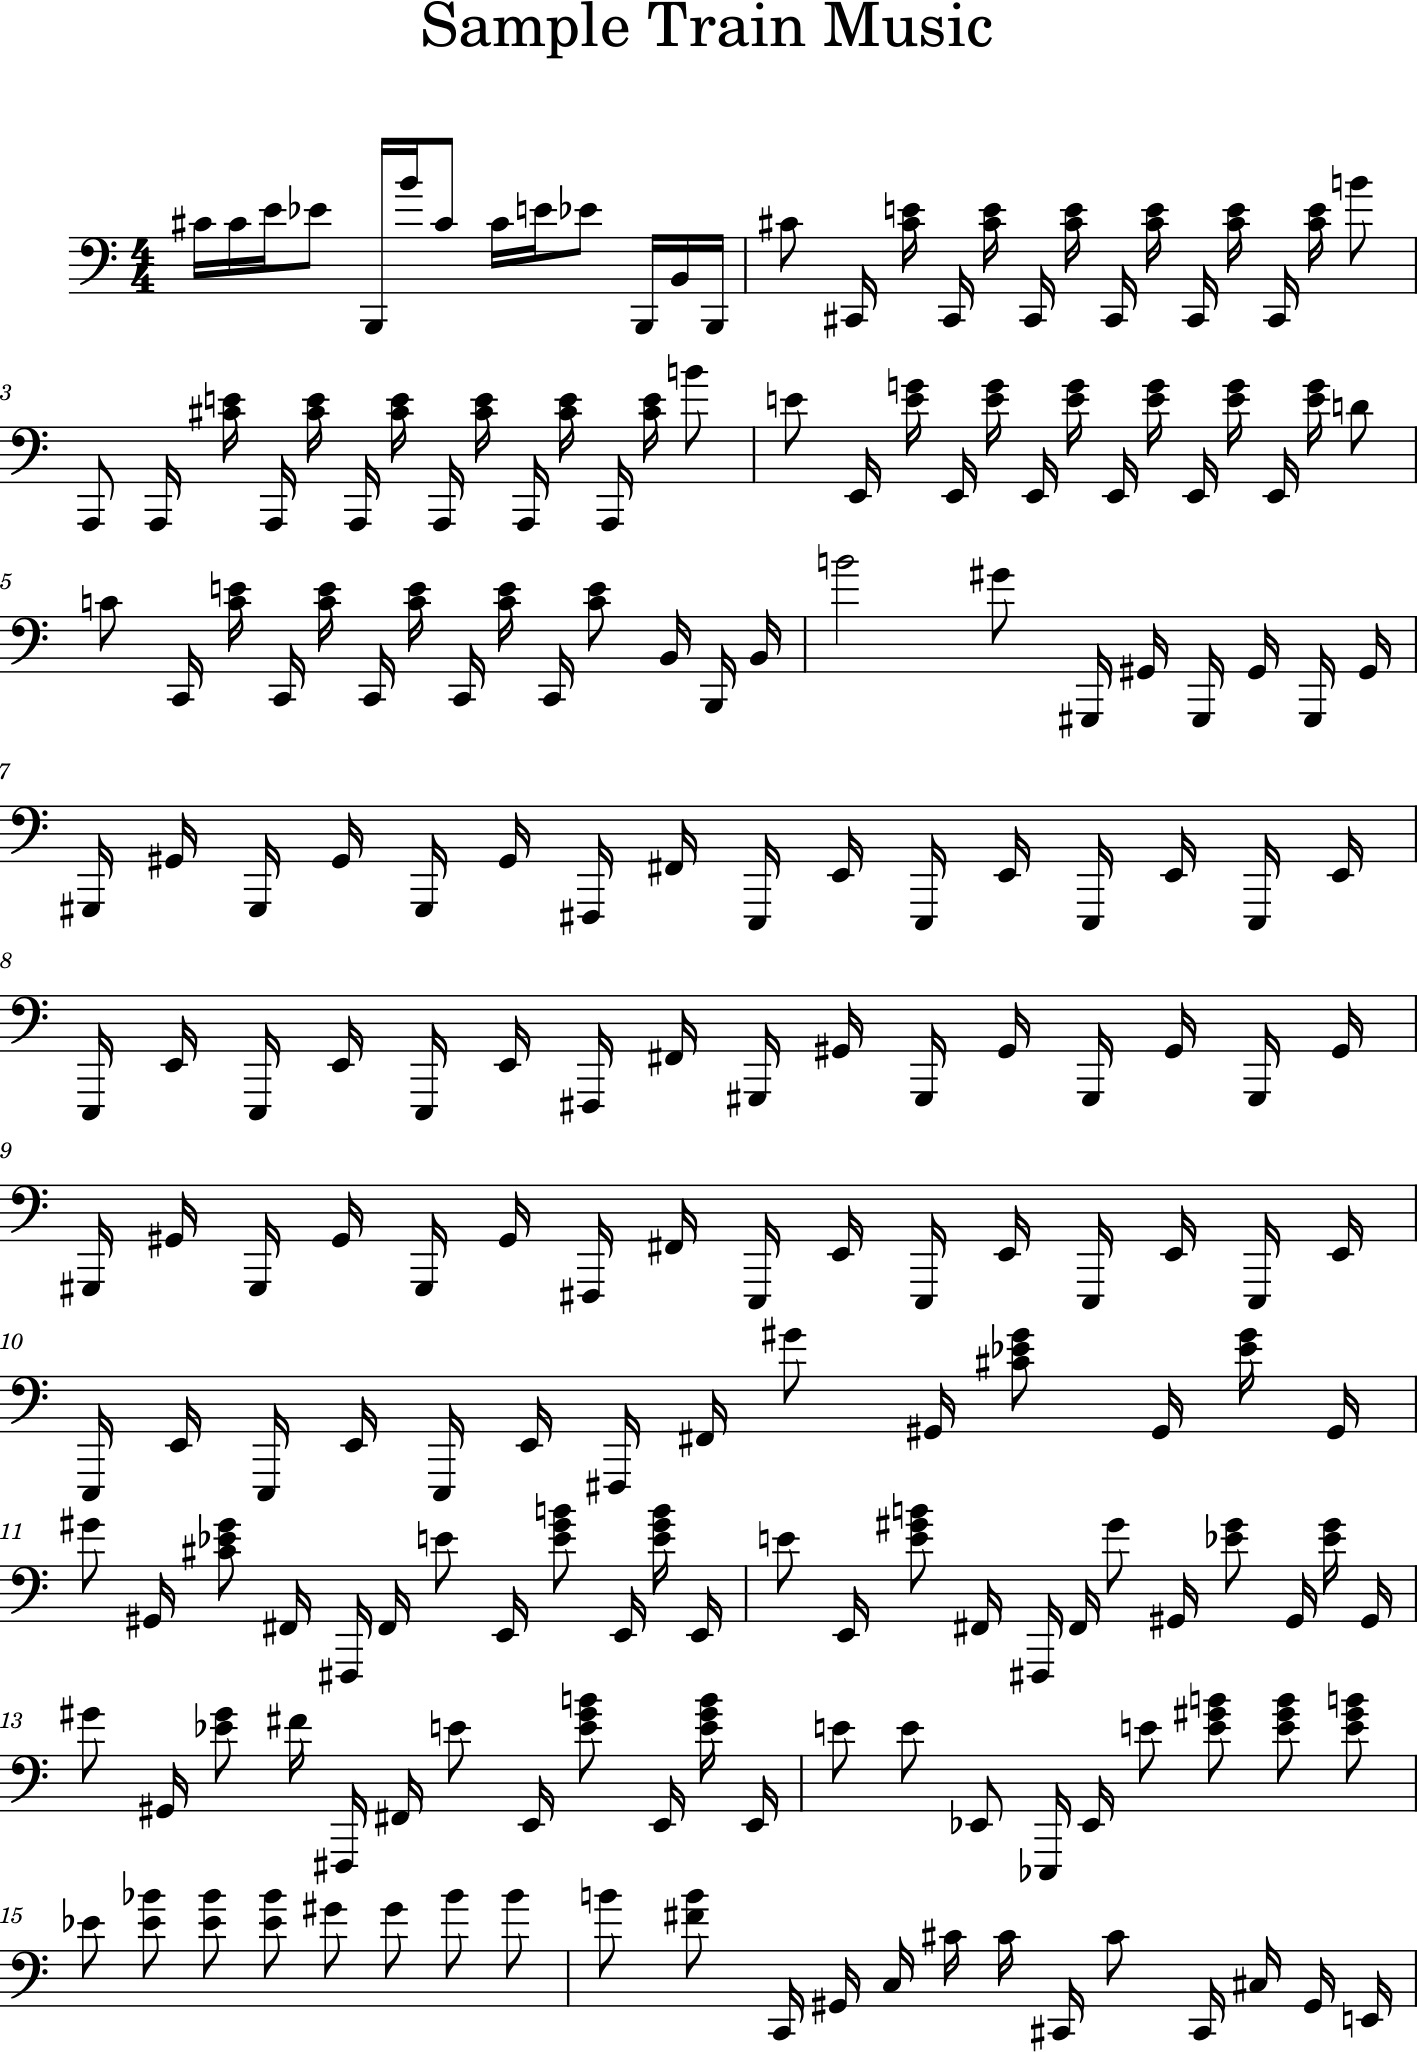

In [9]:
s.show()

In [10]:
s.show('midi')

### Data Preparation

In [11]:
# every note in a 1d array
notes_ = [element for note_ in notes_array for element in note_]

In [12]:
# frequency of each note
freq = dict(Counter(notes_))

In [13]:
# list of frequent notes, adjustable by count
frequent_notes = [note_ for note_, count in freq.items() if count>=frequentNoteMin]
print("# of frequent notes:", len(frequent_notes))

# of frequent notes: 489


In [14]:
# new_music = notes - nonfrequent notes
new_music=[]

for notes in notes_array:
    temp=[]
    for note_ in notes:
        if note_ in frequent_notes:
            temp.append(note_)            
    new_music.append(temp)

In [15]:
# prepare input and output sequences
x = []
y = []

for note_ in new_music:
    for i in range(0, len(note_) - no_of_timesteps, 1):
        
        #preparing input and output sequences
        input_ = note_[i:i + no_of_timesteps]
        output_ = note_[i + no_of_timesteps]
        
        x.append(input_)
        y.append(output_)
        

print("input shape:\t", np.asarray(x).shape)
print("output shape:\t", np.asarray(y).shape)

input shape:	 (30209, 32, 2)
output shape:	 (30209, 2)


In [16]:
# unique note --> integer
unique_x=[]
for i in range(len(x)):
    for j in range(len(x[i])):
        unique_x.append(x[i][j])
unique_x = list(set(unique_x))
x_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_x))

with open(unique_x_file, "w") as output:
    for element in unique_x:
        output.write(str(element)+'\n')

In [17]:
len(unique_x)

489

In [18]:
# x_seq <--> model input
x_seq=[]
for i in x:
    temp=[]
    for j in i:
        #assigning unique integer to every note
        temp.append(x_note_to_int[j])
    x_seq.append(temp)
    
x_seq = np.array(x_seq)

In [19]:
# same procedure as x_seq but simpler
unique_y = list(set(y))
y_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_y)) 
y_seq = np.array([y_note_to_int[i] for i in y])

In [20]:
# train/test partitioning, test_size=0.2 --> 20% of data is test
x_tr, x_val, y_tr, y_val = train_test_split(x_seq,y_seq,test_size=0.2,random_state=0)
np.savetxt(xval_file, x_val)

In [21]:
# metadata
print("Shapes:")
print("x_tr:", x_tr.shape)
print("y_tr:", y_tr.shape)
print("x_val:", x_val.shape)
print("y_val:", y_val.shape)

Shapes:
x_tr: (24167, 32)
y_tr: (24167,)
x_val: (6042, 32)
y_val: (6042,)


### Neural Network

In [22]:
def lstm(input_shape, output_shape):
    K.clear_session()
    model = Sequential()
    
    #embedding layer
    model.add(Embedding(input_shape, 100, input_length=32,trainable=True))
    
    model.add(LSTM(128,return_sequences=True))
    model.add(LSTM(128))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dense(output_shape))
    model.add(Activation('softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
    return model

model = lstm(len(unique_x), len(unique_y))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 100)           48900     
                                                                 
 lstm (LSTM)                 (None, 32, 128)           117248    
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 489)               125673    
                                                                 
 activation_1 (Activation)   (None, 489)               0

In [23]:
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [24]:
# training
if validation:
    mc = ModelCheckpoint(model_name, mode='min', verbose=1, save_best_only=True)
    history = model.fit(np.array(x_tr),np.array(y_tr),batch_size=128,epochs=epochs, validation_data=(np.array(x_val),np.array(y_val)),verbose=1, callbacks=[mc])
else:
    mc = ModelCheckpoint(model_name, mode='min', verbose=1)
    history = model.fit(np.array(x_seq),np.array(y_seq),batch_size=128,epochs=epochs, verbose=1, callbacks=[mc, tensorboard_callback])
    
# can stop kernel if loss does not consistently decrease (converges)

Epoch 1/100
236/237 [============================>.] - ETA: 0s - loss: 5.3258
Epoch 1: saving model to PianoAnime.h5
237/237 [==============================] - 45s 172ms/step - loss: 5.3257
Epoch 2/100
236/237 [============================>.] - ETA: 0s - loss: 4.4465
Epoch 2: saving model to PianoAnime.h5
237/237 [==============================] - 40s 168ms/step - loss: 4.4465
Epoch 3/100
236/237 [============================>.] - ETA: 0s - loss: 3.9704
Epoch 3: saving model to PianoAnime.h5
237/237 [==============================] - 38s 161ms/step - loss: 3.9704
Epoch 4/100
236/237 [============================>.] - ETA: 0s - loss: 3.6212
Epoch 4: saving model to PianoAnime.h5
237/237 [==============================] - 38s 162ms/step - loss: 3.6212
Epoch 5/100
236/237 [============================>.] - ETA: 0s - loss: 3.3611
Epoch 5: saving model to PianoAnime.h5
237/237 [==============================] - 40s 168ms/step - loss: 3.3611
Epoch 6/100
236/237 [============================>

Epoch 44/100
236/237 [============================>.] - ETA: 0s - loss: 0.1955
Epoch 44: saving model to PianoAnime.h5
237/237 [==============================] - 39s 165ms/step - loss: 0.1955
Epoch 45/100
236/237 [============================>.] - ETA: 0s - loss: 0.1735
Epoch 45: saving model to PianoAnime.h5
237/237 [==============================] - 39s 164ms/step - loss: 0.1735
Epoch 46/100
236/237 [============================>.] - ETA: 0s - loss: 0.1743
Epoch 46: saving model to PianoAnime.h5
237/237 [==============================] - 40s 169ms/step - loss: 0.1743
Epoch 47/100
236/237 [============================>.] - ETA: 0s - loss: 0.1679
Epoch 47: saving model to PianoAnime.h5
237/237 [==============================] - 41s 173ms/step - loss: 0.1679
Epoch 48/100
236/237 [============================>.] - ETA: 0s - loss: 0.2613
Epoch 48: saving model to PianoAnime.h5
237/237 [==============================] - 40s 169ms/step - loss: 0.2613
Epoch 49/100
236/237 [==================

KeyboardInterrupt: 

In [26]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 11276), started 16:06:38 ago. (Use '!kill 11276' to kill it.)